###Double Lasso
We first set up our condition since most minimum wage change occured in 1997. We identify States that has a change in minimum wage in 1997 as treatment group.The rest of the states to control group. We use the MW to gather a new information line called Delta%changeMW. The original passage follows a three years before and five years after rotation. We use double lasso to enhance paralell assumption, in order to do that we select a median level of change occurs from treatment group from the parameter Deltachange%MW and compare use Double Lasso to compute it with all the components from control group.
###Data cleaning
We set the state with no change on minimum wage to pair with our result of 0 on our new parameter, and generate six changes for each state in order to use double lasso we need to set our new parameter with same quantity on our new parameter.

In [ ]:
import pandas as pd

# Read the additional data file
excel_path = '/content/StateMinimumWage_Changes.xlsx'
df = pd.read_excel(excel_path)
# Filter out states without data for 1997
states_without_1997 = df[~df['statename'].isin(df.loc[df['year'] == 1997, 'statename'])]['statename'].unique()
df_filtered = df[df['statename'].isin(states_without_1997)]
# Save to CSV
output_csv_path = 'filtered_data_from_excel.csv'
df_filtered.to_csv(output_csv_path, index=False)
#Fill the empty years
required_years = [1990, 1991, 1992, 1993, 1994, 1995, 1996]
processed_df = pd.DataFrame()

for state in states_without_1997:
    state_data = df_filtered[df_filtered['statename'] == state].copy()
    for year in required_years:
        if year not in state_data['year'].values:
            new_row = {
                'statefips': state_data.iloc[0]['statefips'] if not state_data.empty else 'NaN',
                'statename': state,
                'year': year,
                'month': 1,
                'day': 1,
                'mw': 0,
                'changeinmw': 0
            }
            state_data = pd.concat([state_data, pd.DataFrame([new_row])], ignore_index=True)
    processed_df = pd.concat([processed_df, state_data], ignore_index=True)

# delete duplicate
processed_df.sort_values(by=['statename', 'year'], inplace=True)
processed_df.drop_duplicates(subset=['statename', 'year'], keep='first', inplace=True)

# compute changeinmw and changeinmw_ratio
processed_df['changeinmw'] = processed_df.groupby('statename')['mw'].diff().fillna(0).clip(lower=0)
processed_df['changeinmw_ratio'] = processed_df.groupby('statename')['changeinmw'].transform(lambda x: x / x.shift(1))
processed_df['changeinmw_ratio'] = processed_df['changeinmw_ratio'].replace([float('inf'), -float('inf')], 0).fillna(0)

# save to csv
final_output_csv_with_ratio_path = 'final_processed_with_ratio_in_mw.csv'
processed_df.to_csv(final_output_csv_with_ratio_path, index=False)

print(f"Processed data with ratio in change in mw saved to {final_output_csv_with_ratio_path}")

import pandas as pd
from sklearn.linear_model import LassoCV

# read Arkansas data
arkansas_template = pd.DataFrame({
    'year': [1990, 1991, 1992, 1993, 1994, 1995],
    'changeinmw': [0, 0, 0.35, 0.15, 0.1, 0]  # 假设值，实际值应该是你计算出来的
})

# read
final_df = pd.read_csv('/mnt/data/final_processed_with_ratio_in_mw.csv')

# fill empty years
filled_final_df = pd.DataFrame()
years_to_fill = range(1990, 1996)
for state in final_df['statename'].unique():
    state_data = final_df[final_df['statename'] == state]
    filled_years = state_data['year'].unique()
    for year in years_to_fill:
        if year not in filled_years:
            missing_row = {
                'statefips': state_data.iloc[0]['statefips'] if not state_data.empty else 'NaN',
                'statename': state,
                'year': year,
                'changeinmw': 0  # 填充0
            }
            state_data = pd.concat([state_data, pd.DataFrame([missing_row])], ignore_index=True)
    filled_final_df = pd.concat([filled_final_df, state_data], ignore_index=True)

filled_final_df.sort_values(by=['statename', 'year'], inplace=True)
filled_final_df.reset_index(drop=True, inplace=True)

# Run Double Lasso
best_state = None
best_score = float('-inf')

for state in filled_final_df['statename'].unique():
    if state != 'Arkansas':
        state_data = filled_final_df[filled_final_df['statename'] == state]

        state_data = state_data[state_data['year'].isin(arkansas_template['year'])]
        X = state_data[['year', 'changeinmw']].values
        y = arkansas_template['changeinmw'].values
        # cross validation
        lasso = LassoCV(cv=5).fit(X, y)
        score = lasso.score(X, y)
        if score > best_score:
            best_score = score
            best_state = state

print(f"The state most similar to Arkansas based on changeinmw is: {best_state}")



/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Processed data with ratio in change in mw saved to final_processed_with_ratio_in_mw.csv


In [ ]:


import pandas as pd
from sklearn.linear_model import LassoCV


arkansas_template = pd.DataFrame({
    'year': [1990, 1991, 1992, 1993, 1994, 1995],
    'changeinmw': [0, 0, 0.35, 0.15, 0.1, 0]  # 假设值，实际值应该是你计算出来的
})

#read
final_df = pd.read_csv('/content/final_processed_with_ratio_in_mw.csv')

# fill empty years
filled_final_df = pd.DataFrame()
years_to_fill = range(1990, 1996)
for state in final_df['statename'].unique():
    state_data = final_df[final_df['statename'] == state]
    filled_years = state_data['year'].unique()
    for year in years_to_fill:
        if year not in filled_years:
            missing_row = {
                'statefips': state_data.iloc[0]['statefips'] if not state_data.empty else 'NaN',
                'statename': state,
                'year': year,
                'changeinmw': 0  # 填充0
            }
            state_data = pd.concat([state_data, pd.DataFrame([missing_row])], ignore_index=True)
    filled_final_df = pd.concat([filled_final_df, state_data], ignore_index=True)

filled_final_df.sort_values(by=['statename', 'year'], inplace=True)
filled_final_df.reset_index(drop=True, inplace=True)

#run double lasso
best_state = None
best_score = float('-inf')

for state in filled_final_df['statename'].unique():
    if state != 'Arkansas':
        state_data = filled_final_df[filled_final_df['statename'] == state]

        state_data = state_data[state_data['year'].isin(arkansas_template['year'])]
        X = state_data[['year', 'changeinmw']].values
        y = arkansas_template['changeinmw'].values

        lasso = LassoCV(cv=5).fit(X, y)
        score = lasso.score(X, y)
        if score > best_score:
            best_score = score
            best_state = state

print(f"The state most similar to Arkansas based on changeinmw is: {best_state}")



The state most similar to Arkansas based on changeinmw is: New York


# Replicating Figure II of the Paper -- "Impact of Minimum Wages on the Wage Distribution"

## 1. Data Cloning from Github

### This block of code is designed to acquire and prepare data for a data science project focused on economic and social issues. Here's a breakdown of what each part does and the tasks it accomplishes:

- Cloning the Repository: The git clone command is used to clone (i.e., download) a complete repository from GitHub that contains the data science project on economic and social issues into the current working environment. This ensures all files and data within the repository are available locally.
- Changing the Working Directory: The %cd command changes the current working directory to the root of the cloned repository, ensuring that subsequent operations are performed within the correct folder.
- Entering a Specific Subfolder: If specific data or scripts within the repository are needed, the code uses another %cd command to navigate into a subdirectory that contains the desired data.
- Importing Data Handling Library: The code imports the pandas library, which is a primary tool in Python for data analysis and manipulation.
- Listing Files: It uses the !ls command to list all files in the current directory. This step verifies the presence of a specific data file, such as Figure2_for_QJE.dta.zip, which is expected to be in the repository.
- Unzipping the Data File: The !unzip command is used to decompress the .zip file to extract the Stata data file (.dta file) contained within.
- Reading and Checking the Data: The read_stata function from pandas is utilized to read the extracted .dta file into a DataFrame object. The head function is then called to print the first few rows of the DataFrame to ensure the data has been loaded correctly and is free of initial errors.
- The entire process marks the beginning of a data analysis workflow, involving acquiring data from remote resources, verifying the presence of files, and preparing data for further analysis or processing. These steps are typically automated and repetitive, aimed at reducing the need for manual data handling.

In [3]:
!pip install linearmodels
import pandas as pd
from linearmodels.panel import PanelOLS

# Clone the repository and navigate to the appropriate directory
!git clone https://github.com/mjahangiralam/Data-Science-for-Economic-and-Social-Issues.git
%cd Data-Science-for-Economic-and-Social-Issues/DiD/Cengiz-et-al

# Unzip the data file
!unzip Figure2_for_QJE.dta.zip

# Load the data
df = pd.read_stata('Figure2_for_QJE.dta')
df.set_index(['wagebinstate', 'quarterdate'], inplace=True)

# Filter to select only states with statenum 5 and 35
states_of_interest = [5, 35]
filtered_df = df[df['statenum'].isin(states_of_interest)]

# Define parameters
b = 1979  # Base year
tmax = 16  # Maximum time period for treatment

# Construct placeboafter1 variable
placeboafter1 = ""
for k in range(0, tmax + 1, 4):
    K = f"L{k}" if k > 0 else ""
    placeboafter1 += " + ".join([f"{K}treat_p{j}" for j in range(10)]) + " + "
placeboafter1 = placeboafter1.strip(" + ")

# Define control variables
control_vars = ['controlbefore', 'controlafter', 'window',
                'placebocontafter2', 'windowpl2', 'placebobefore2',
                'placebobefore1', 'windowpl1', 'controlf', 'control']

# Combine all variables for regression
all_vars = placeboafter1.split(' + ') + control_vars + ['const']

# Ensure all variables exist in df, add constant term
filtered_df['const'] = 1
all_vars = [var for var in all_vars if var in filtered_df.columns]  # Filter out any non-existing columns

# Filter based on condition
final_df = filtered_df[(filtered_df['year'] >= b) & (filtered_df['cleansample'] == 1)]

# Dependent variable
Y = 'overallcountpc'  # Ensure this column name exists in DataFrame

# Perform panel regression
model = PanelOLS(final_df[Y], final_df[all_vars], entity_effects=True)
results = model.fit(cov_type='clustered', cluster_entity=True)

# Print regression results
print(results.summary)

# Extract and print regression coefficients
coefficients = results.params
print("Regression Coefficients:")
print(coefficients)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 5.2 MB/s eta 0:00:00
Cloning into 'Data-Science-for-Economic-and-Social-Issues'...
remote: Enumerating objects: 408, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 408 (delta 19), reused 72 (delta 16), pack-reused 332
Receiving objects: 100% (408/408), 273.20 MiB | 27.50 MiB/s, done.
Resolving deltas: 100% (186/186), done.
Updating files: 100% (341/341), done.
/content/Data-Science-for-Economic-and-Social-Issues/DiD/Cengiz-et-al
Archive:  Figure2_for_QJE.dta.zip
  inflating: Figure2_for_QJE.dta     


<ipython-input-3-49b3b748d991>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_df['const'] = 1
<ipython-input-3-49b3b748d991>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['const'] = 1
/usr/local/lib/python3.10/dist-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:         overallcountpc   R-squared:                        0.0025
Estimator:                   PanelOLS   R-squared (Between):             -0.0055
No. Observations:               33228   R-squared (Within):               0.0025
Date:                Mon, May 06 2024   R-squared (Overall):             -0.0021
Time:                        15:51:37   Log-likelihood                 1.305e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.6714
Entities:                         234   P-value                           0.0021
Avg Obs:                       142.00   Distribution:                F(50,32944)
Min Obs:                       142.00                                           
Max Obs:                       142.00   F-statistic (robust):             3.6504
                            

In [4]:
import pandas as pd
from linearmodels import PanelOLS

# Load data
df = pd.read_stata('Figure2_for_QJE.dta')
df.set_index(['wagebinstate', 'quarterdate'], inplace=True)

# Filter to select only states with statenum 5 and 36
states_of_interest = [5, 36]
filtered_df = df[df['statenum'].isin(states_of_interest)]

# Define global variables and parameters
wmax = 4
wmin = 4
tmax = 16
tmin = 12
truewmin = 4
truewmax = 4

# Construct variables
treatment_effects = ""
for k in range(0, tmax + 1, 4):
    K = f"L{k}" if k > 0 else ""
    treatment_effects += " + ".join([f"{K}treat_p{j}" for j in range(0, wmax + 1)]) + " + "

# Strip trailing '+' and split to create a list of variable names
independent_vars_list = treatment_effects.strip(' + ').split(' + ')
independent_vars_list = [var for var in independent_vars_list if var in filtered_df.columns]  # Ensure variables are in df

# Add constant term
filtered_df['const'] = 1

# Select columns for regression
X = filtered_df[independent_vars_list + ['const']]

# Dependent variable
Y = filtered_df['overallcountpcall']  # Make sure this column name exists in DataFrame

# Perform regression
model = PanelOLS(Y, X, entity_effects=True)
results = model.fit(cov_type='clustered', cluster_entity=True)

# Print regression results
print(results.summary)

# Extract regression coefficients
coefficients = results.params
print("Regression coefficients:")
print(coefficients)


<ipython-input-4-c3b7022c4882>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_df['const'] = 1
<ipython-input-4-c3b7022c4882>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['const'] = 1
/usr/local/lib/python3.10/dist-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:      overallcountpcall   R-squared:                        0.0043
Estimator:                   PanelOLS   R-squared (Between):              0.0071
No. Observations:               34866   R-squared (Within):               0.0043
Date:                Mon, May 06 2024   R-squared (Overall):              0.0053
Time:                        15:54:03   Log-likelihood                 6.962e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      6.0265
Entities:                         234   P-value                           0.0000
Avg Obs:                       149.00   Distribution:                F(25,34607)
Min Obs:                       149.00                                           
Max Obs:                       149.00   F-statistic (robust):          1.407e+04
                            

In [8]:
import pandas as pd
from linearmodels.panel import PanelOLS

# Load data
df = pd.read_stata('Figure2_for_QJE.dta')
df.set_index(['wagebinstate', 'quarterdate'], inplace=True)

# Filter to select only states with statenum 5 and 36
states_of_interest = [5, 36]
filtered_df = df[df['statenum'].isin(states_of_interest)]

# Define basic parameters
wmax = 4  # Maximum positive lag
wmin = 4  # Maximum negative lag
tmax = 16  # Maximum time period

# Construct treatment effects variable
treatment_effects = ""
for k in range(0, tmax + 1, 4):
    K = f"L{k}" if k > 0 else ""
    # Adding positive treatment effects
    treatment_effects += " + ".join([f"{K}treat_p{j}" for j in range(0, wmax + 4)]) + " + "
    # Adding negative treatment effects
    treatment_effects += " + ".join([f"{K}treat_m{j}" for j in range(0, wmin + 4)]) + " + "

# Strip the trailing " + " and split to list
independent_vars_list = treatment_effects.strip(' + ').split(' + ')

# Define control variables
control_vars = ['controlbefore', 'window', 'placebocontafter1', 'placebobefore1',
                'windowpl1', 'placebocontafter2', 'placebobefore2', 'windowpl2', 'controlf', 'control']

# Combine all variables for regression
all_vars = independent_vars_list + control_vars + ['const']

# Ensure all variables exist in df, add constant term
filtered_df['const'] = 1
all_vars = [var for var in all_vars if var in filtered_df.columns]  # Filter out any non-existing columns

# Dependent variable
Y = 'overallcountpc'  # Ensure this column name exists in DataFrame

# Perform panel regression
model = PanelOLS(filtered_df[Y], filtered_df[all_vars], entity_effects=True)
results = model.fit(cov_type='clustered', cluster_entity=True)


# Extract and print regression coefficients
coefficients = results.params
print("Regression Coefficients:")
print(coefficients)
import pandas as pd
import numpy as np
import re
from linearmodels.panel import PanelOLS

# Assuming you've already loaded and prepared your DataFrame as `df`
# Perform panel regression
model = PanelOLS(df['overallcountpc'], df[['const'] + independent_vars_list], entity_effects=True)
results = model.fit(cov_type='clustered', cluster_entity=True)

# Extract and use regression coefficients automatically
coefficients = results.params.to_dict()  # Convert to dictionary for easier manipulation
print("Regression Coefficients:")
print(coefficients)

# Define variables for calculation
E = 0.5796588659286499  # Example expected value from earlier results; replace with actual if different
tmax = 16
denominator = 1 / (1 + (tmax / 4))
truewmax = 4
truewmin = 4
wmax = truewmax
wmin = truewmin

# Function to create the formula for linear combination
def create_formula(prefix, j, tmax, E, denominator):
    formula = f"[{prefix}{j}] * (4) * (1 / {E})"
    for t in range(4, tmax + 1, 4):
        formula += f" + [L{t}{prefix}{j}] * (4) * (1 / {E})"
    return f"{denominator} * ({formula})"

# Construct regressions for positive and negative indices
PA_p0 = create_formula("treat_p", "0", tmax, E, denominator)
PA_p = {j: create_formula("treat_p", str(j), tmax, E, denominator) for j in range(1, wmax + 1)}
PA_m = {j: create_formula("treat_m", str(j), tmax, E, denominator) for j in range(1, wmin + 1)}

# Define linear combination function
def linear_combination(coefficients, formula):
    variables = re.findall(r"\[([^\]]+)\]", formula)
    formula_list = np.array([coefficients.get(var, 0) for var in variables if var in coefficients])
    est = eval(formula.replace("[", "coefficients.get('").replace("]", "', 0)"))
    variance = np.dot(formula_list, formula_list)
    se = np.sqrt(variance)
    return est, se

# Construct countmat
countmat = []
for k in range(-wmin, wmax + 1):
    if k < 0:
        j = -k
        lincomline = PA_m[j]
    elif k == 0:
        lincomline = PA_p0
    else:
        lincomline = PA_p[k]

    estimate, se = linear_combination(coefficients, lincomline)
    countmat.append([k, estimate, estimate - 1.96 * se, estimate + 1.96 * se])

# Export to dataframe
countmat_df = pd.DataFrame(countmat, columns=["k", "estimate", "ci_lower", "ci_upper"])
print(countmat_df)


<ipython-input-8-e2c3a490c3a5>:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_df['const'] = 1
<ipython-input-8-e2c3a490c3a5>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['const'] = 1
/usr/local/lib/python3.10/dist-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Regression Coefficients:
treat_p0       0.000413
treat_p1       0.000360
treat_p2       0.000016
treat_p3      -0.000645
treat_p4       0.000334
                 ...   
L16treat_m4   -0.000321
L16treat_m5   -0.000059
L16treat_m6   -0.000143
L16treat_m7   -0.000114
const          0.004601
Name: parameter, Length: 76, dtype: float64


KeyError: "['const', 'treat_m0', 'L4treat_m0', 'L8treat_m0', 'L12treat_m0', 'L16treat_m0'] not in index"

In [9]:
import pandas as pd
import numpy as np
import re
from linearmodels.panel import PanelOLS

# Load data
df = pd.read_stata('Figure2_for_QJE.dta')
df.set_index(['wagebinstate', 'quarterdate'], inplace=True)

# Filter to select only states with statenum 5 and 36
states_of_interest = [5, 36]
filtered_df = df[df['statenum'].isin(states_of_interest)]

# Define basic parameters
wmax = 4  # Maximum positive lag
wmin = 4  # Maximum negative lag
tmax = 16  # Maximum time period

# Construct treatment effects variable
treatment_effects = ""
for k in range(0, tmax + 1, 4):
    K = f"L{k}" if k > 0 else ""
    # Adding positive treatment effects
    treatment_effects += " + ".join([f"{K}treat_p{j}" for j in range(0, wmax + 4)]) + " + "
    # Adding negative treatment effects, only if j > 0 (there is no treat_m0 normally)
    treatment_effects += " + ".join([f"{K}treat_m{j}" for j in range(1, wmin + 4)]) + " + "

# Strip the trailing " + " and split to list
independent_vars_list = treatment_effects.strip(' + ').split(' + ')

# Define control variables
control_vars = ['controlbefore', 'window', 'placebocontafter1', 'placebobefore1',
                'windowpl1', 'placebocontafter2', 'placebobefore2', 'windowpl2', 'controlf', 'control']

# Combine all variables for regression
all_vars = independent_vars_list + control_vars + ['const']

# Ensure all variables exist in filtered_df, add constant term
filtered_df['const'] = 1
all_vars = [var for var in all_vars if var in filtered_df.columns]  # Filter out any non-existing columns

print("Variables used in regression:", all_vars)  # Debugging print

# Dependent variable
Y = 'overallcountpc'  # Ensure this column name exists in DataFrame

# Perform panel regression
model = PanelOLS(filtered_df[Y], filtered_df[all_vars], entity_effects=True)
results = model.fit(cov_type='clustered', cluster_entity=True)

# Extract and print regression coefficients
coefficients = results.params.to_dict()  # Convert to dictionary for easier manipulation
print("Regression Coefficients:")
print(coefficients)

# Define variables for calculation
E = 0.5796588659286499  # Example expected value from earlier results; replace with actual if different
tmax = 16
denominator = 1 / (1 + (tmax / 4))
truewmax = 4
truewmin = 4
wmax = truewmax
wmin = truewmin

# Other calculations follow based on the presence of required coefficients...

# Define a function to create the formula for linear combination
def create_formula(prefix, j, tmax, E, denominator):
    formula = f"[{prefix}{j}] * (4) * (1 / {E})"
    for t in range(4, tmax + 1, 4):
        formula += f" + [L{t}{prefix}{j}] * (4) * (1 / {E})"
    return f"{denominator} * ({formula})"

# Construct formulas for positive and negative treatment effects
PA_p0 = create_formula("treat_p", "0", tmax, E, denominator)
PA_p = {j: create_formula("treat_p", str(j), tmax, E, denominator) for j in range(1, wmax + 1)}
PA_m = {j: create_formula("treat_m", str(j), tmax, E, denominator) for j in range(1, wmin + 1)}

# Define a function to compute the linear combination
def linear_combination(coefficients, formula):
    variables = re.findall(r"\[([^\]]+)\]", formula)
    formula_list = np.array([coefficients.get(var, 0) for var in variables if var in coefficients])
    est = eval(formula.replace("[", "coefficients.get('").replace("]", "', 0)"))
    variance = np.dot(formula_list, formula_list)
    se = np.sqrt(variance)
    return est, se

# Construct countmat for each index from -wmin to wmax
countmat = []
for k in range(-wmin, wmax + 1):
    if k < 0:
        j = -k
        lincomline = PA_m[j]
    elif k == 0:
        lincomline = PA_p0
    else:
        lincomline = PA_p[k]

    estimate, se = linear_combination(coefficients, lincomline)
    countmat.append([k, estimate, estimate - 1.96 * se, estimate + 1.96 * se])

# Export to dataframe and print
countmat_df = pd.DataFrame(countmat, columns=["k", "estimate", "ci_lower", "ci_upper"])
print(countmat_df)


<ipython-input-9-37bf5aac9439>:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_df['const'] = 1
<ipython-input-9-37bf5aac9439>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['const'] = 1
/usr/local/lib/python3.10/dist-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Variables used in regression: ['treat_p0', 'treat_p1', 'treat_p2', 'treat_p3', 'treat_p4', 'treat_p5', 'treat_p6', 'treat_p7', 'treat_m1', 'treat_m2', 'treat_m3', 'treat_m4', 'treat_m5', 'treat_m6', 'treat_m7', 'L4treat_p0', 'L4treat_p1', 'L4treat_p2', 'L4treat_p3', 'L4treat_p4', 'L4treat_p5', 'L4treat_p6', 'L4treat_p7', 'L4treat_m1', 'L4treat_m2', 'L4treat_m3', 'L4treat_m4', 'L4treat_m5', 'L4treat_m6', 'L4treat_m7', 'L8treat_p0', 'L8treat_p1', 'L8treat_p2', 'L8treat_p3', 'L8treat_p4', 'L8treat_p5', 'L8treat_p6', 'L8treat_p7', 'L8treat_m1', 'L8treat_m2', 'L8treat_m3', 'L8treat_m4', 'L8treat_m5', 'L8treat_m6', 'L8treat_m7', 'L12treat_p0', 'L12treat_p1', 'L12treat_p2', 'L12treat_p3', 'L12treat_p4', 'L12treat_p5', 'L12treat_p6', 'L12treat_p7', 'L12treat_m1', 'L12treat_m2', 'L12treat_m3', 'L12treat_m4', 'L12treat_m5', 'L12treat_m6', 'L12treat_m7', 'L16treat_p0', 'L16treat_p1', 'L16treat_p2', 'L16treat_p3', 'L16treat_p4', 'L16treat_p5', 'L16treat_p6', 'L16treat_p7', 'L16treat_m1', 'L16treat

In [11]:
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS

# Clone the repository and navigate to the appropriate directory
!git clone https://github.com/mjahangiralam/Data-Science-for-Economic-and-Social-Issues.git
%cd Data-Science-for-Economic-and-Social-Issues/DiD/Cengiz-et-al

# List files to confirm the data file exists
!ls

# Unzip the data file
!unzip Figure2_for_QJE.dta.zip

# Load the data
df = pd.read_stata('Figure2_for_QJE.dta')
df.set_index(['wagebinstate', 'quarterdate'], inplace=True)

# Define parameters
b = 1979  # Replacement for `b` in Stata code
wmax = 4
wmin = 4
tmax = 16

# Construct placeboafter1 variable
placeboafter1 = ""
for k in range(0, tmax + 1, 4):
    K = f"L{k}" if k > 0 else ""
    placeboafter1 += " + ".join([f"{K}treat_p{j}" for j in range(0, wmin + 10)]) + " + "
placeboafter1 = placeboafter1.strip(" + ")

# Define control variables
control_vars = ['controlbefore', 'controlafter', 'window',
                'placebocontafter2', 'windowpl2', 'placebobefore2',
                'placebobefore1', 'windowpl1', 'controlf', 'control']

# Combine all variables for regression
all_vars = placeboafter1.split(' + ') + control_vars + ['const']

# Ensure all variables exist in df, add constant term
df['const'] = 1
all_vars = [var for var in all_vars if var in df.columns]  # Filter out any non-existing columns

# Filter the DataFrame to only include states with statenum 5 and 36
filtered_df = df[(df['year'] >= b) & (df['cleansample'] == 1) & df['statenum'].isin([5, 36])]

# Dependent variable
Y = 'overallcountpc'  # Ensure this column name exists in DataFrame

# Perform panel regression
model = PanelOLS(filtered_df[Y], filtered_df[all_vars], entity_effects=True)
results = model.fit(cov_type='clustered', cluster_entity=True)

print(results.summary)

# Extract and print regression coefficients
coefficients = results.params
print("Regression Coefficients:")
print(coefficients)


Cloning into 'Data-Science-for-Economic-and-Social-Issues'...
remote: Enumerating objects: 408, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 408 (delta 19), reused 72 (delta 16), pack-reused 332
Receiving objects: 100% (408/408), 273.20 MiB | 27.48 MiB/s, done.
Resolving deltas: 100% (186/186), done.
Updating files: 100% (341/341), done.
/content/Data-Science-for-Economic-and-Social-Issues/DiD/Cengiz-et-al/Data-Science-for-Economic-and-Social-Issues/DiD/Cengiz-et-al/Data-Science-for-Economic-and-Social-Issues/DiD/Cengiz-et-al
Figure2_for_QJE.dta.zip  Table1_for_QJE.dta.zip
Archive:  Figure2_for_QJE.dta.zip
  inflating: Figure2_for_QJE.dta     


<ipython-input-11-cd023a81d969>:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['const'] = 1
/usr/local/lib/python3.10/dist-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:         overallcountpc   R-squared:                        0.0025
Estimator:                   PanelOLS   R-squared (Between):             -0.0002
No. Observations:               33228   R-squared (Within):               0.0025
Date:                Mon, May 06 2024   R-squared (Overall):              0.0004
Time:                        16:12:32   Log-likelihood                   1.3e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.1870
Entities:                         234   P-value                           0.1361
Avg Obs:                       142.00   Distribution:                F(70,32924)
Min Obs:                       142.00                                           
Max Obs:                       142.00   F-statistic (robust):             5.3388
                            

In [12]:
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
import re

# Load and prepare the data as previously described
# Assuming 'filtered_df' and 'all_vars' are prepared and 'model' and 'results' are already obtained
# Continue from the regression output:
coefficients = results.params.to_dict()  # Convert regression coefficients to a dictionary for easier manipulation

# Define variables for calculation
E = 0.5796588659286499
tmax = 16
denominator = 1 / (1 + (tmax / 4))
truewmax = 4
truewmin = 4
placebo1wmax = 13
wmin = truewmax + 1
wmax = placebo1wmax

# Function to create formula
def create_formula(prefix, j, tmax, E, denominator):
    formula = f"[{prefix}{j}] * (4) * (1 / {E})"
    for t in range(4, tmax + 1, 4):
        formula += f" + [L{t}{prefix}{j}] * (4) * (1 / {E})"
    return f"{denominator} * ({formula})"

# Build all formulas for the coefficients
PA_p = {j: create_formula("treat_p", j, tmax, E, denominator) for j in range(wmin, wmax + 1)}

# Define linear combination function
def linear_combination(coefficients, formula):
    variables = re.findall(r"\[([^\]]+)\]", formula)
    formula_list = np.array([coefficients[var] for var in variables])
    est = eval(formula.replace("[", "coefficients['").replace("]", "']"))
    variance = np.dot(formula_list, formula_list)
    se = np.sqrt(variance)
    return est, se

# Calculate linear combinations
countmat = []
for k in range(wmin, wmax + 1):
    lincomline = PA_p[k]
    estimate, se = linear_combination(coefficients, lincomline)
    countmat.append([k, estimate, estimate - 1.96 * se, estimate + 1.96 * se])

# Convert to DataFrame for display
countmat_df = pd.DataFrame(countmat, columns=["k", "estimate", "ci_lower", "ci_upper"])
print(countmat_df)


    k  estimate  ci_lower  ci_upper
0   5 -0.004222 -0.007436 -0.001009
1   6  0.001914 -0.000302  0.004131
2   7 -0.004825 -0.008531 -0.001118
3   8 -0.001525 -0.003762  0.000712
4   9  0.000675 -0.001160  0.002510
5  10 -0.002903 -0.005271 -0.000535
6  11  0.001383  0.000049  0.002718
7  12 -0.004107 -0.007218 -0.000996
8  13  0.000924 -0.001280  0.003127


In [13]:
!pip install linearmodels pandas

import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
import statsmodels.formula.api as smf
import patsy

# Assuming the repository has been cloned and navigated to the appropriate directory elsewhere, or manually
# Commenting these out because executing them in a non-interactive or non-shell environment will fail
# !git clone https://github.com/mjahangiralam/Data-Science-for-Economic-and-Social-Issues.git
# %cd Data-Science-for-Economic-and-Social-Issues/DiD/Cengiz-et-al

# Assuming data has been unzipped elsewhere or manually
# !ls
# !unzip Figure2_for_QJE.dta.zip

# Load the data
df = pd.read_stata('Figure2_for_QJE.dta')
df.set_index(['wagebinstate', 'quarterdate'], inplace=True)

# Define parameters
b = 1979
wmax = 4
wmin = 4
tmax = 16

# Construct placeboafter2 variable
placeboafter2 = ""
for k in range(0, tmax + 1, 4):
    K = f"L{k}" if k > 0 else ""
    placeboafter2 += " + ".join([f"{K}treat_p{j}" for j in range(0, wmin + 18)]) + " + "
placeboafter2 = placeboafter2.strip(" + ")

# Define control variables in the specified order
control_vars = ['controlafter', 'controlbefore', 'window',
                'placebocontafter1', 'placebobefore1', 'windowpl1',
                'placebobefore2', 'windowpl2', 'controlf', 'control']

# Combine all variables for regression
all_vars = placeboafter2.split(' + ') + control_vars + ['const']

# Ensure all variables exist in df, add constant term
df['const'] = 1
all_vars = [var for var in all_vars if var in df.columns]  # Filter out any non-existing columns

# Filter based on condition
filtered_df = df[(df['year'] >= b) & (df['cleansample'] == 1)]

# Dependent variable
Y = 'overallcountpc'

# Perform panel regression
model = PanelOLS(filtered_df[Y], filtered_df[all_vars], entity_effects=True)
results = model.fit(cov_type='clustered', cluster_entity=True)

# Print regression results
print(results.summary)

# Extract and print regression coefficients
coefficients = results.params
print("Regression Coefficients:")
print(coefficients)


<ipython-input-13-9f0631e37f9d>:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['const'] = 1
/usr/local/lib/python3.10/dist-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:         overallcountpc   R-squared:                        0.0009
Estimator:                   PanelOLS   R-squared (Between):              0.0022
No. Observations:              847314   R-squared (Within):               0.0009
Date:                Mon, May 06 2024   R-squared (Overall):              0.0019
Time:                        16:17:52   Log-likelihood                 3.178e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      8.2490
Entities:                        5967   P-value                           0.0000
Avg Obs:                       142.00   Distribution:               F(90,841257)
Min Obs:                       142.00                                           
Max Obs:                       142.00   F-statistic (robust):             2.0381
                            

In [14]:
import numpy as np
import pandas as pd
import re
from linearmodels.panel import PanelOLS

# Assume df is your loaded DataFrame as previously described
# Assuming the filtered_df and all_vars are already correctly set up
Y = 'overallcountpc'  # Ensure this column name exists in DataFrame

# Perform panel regression
model = PanelOLS(filtered_df[Y], filtered_df[all_vars], entity_effects=True)
results = model.fit(cov_type='clustered', cluster_entity=True)

# Extract regression coefficients directly
coefficients = results.params.to_dict()

# Set global parameters for subsequent calculations
E = 0.5796588659286499
tmax = 16
denominator = 1 / (1 + (tmax / 4))
placebo1wmax = 13
placebo2wmax = 16
wmin = placebo1wmax + 1
wmax = placebo2wmax + 1

# Function to create weighted formulas
def create_formula(prefix, j, tmax, E, denominator, numbins=None):
    if numbins is None:
        formula = f"[{prefix}{j}] * (4) * (1 / {E})"
        for t in range(4, tmax + 1, 4):
            formula += f" + [L{t}{prefix}{j}] * (4) * (1 / {E})"
    else:
        formula = f"[{prefix}{j}] * ({numbins}) * (1 / {E})"
        for t in range(4, tmax + 1, 4):
            formula += f" + [L{t}{prefix}{j}] * ({numbins}) * (1 / {E})"
    return f"{denominator} * ({formula})"

# Get numbins
numbins = 2.5  # Adjust according to your needs

# Build all formulas for the coefficients
PA_p = {}
for j in range(wmin, wmax + 1):
    if j != wmax:
        PA_p[j] = create_formula("treat_p", j, tmax, E, denominator)
    else:
        PA_p[j] = create_formula("treat_p", j, tmax, E, denominator, numbins)

# Define linear combination function
def linear_combination(coefficients, formula):
    variables = re.findall(r"\[([^\]]+)\]", formula)
    formula_list = np.array([coefficients.get(var, 0) for var in variables])
    est = eval(formula.replace("[", "coefficients.get('").replace("]", "', 0)"))
    variance = np.dot(formula_list, formula_list)
    se = np.sqrt(variance)
    return est, se

# Calculate linear combinations and confidence intervals
countmat = []
for k in range(wmin, wmax + 1):
    lincomline = PA_p[k]
    estimate, se = linear_combination(coefficients, lincomline)
    countmat.append([k, estimate, estimate - 1.96 * se, estimate + 1.96 * se])

# Convert to DataFrame for display
countmat_df = pd.DataFrame(countmat, columns=["k", "estimate", "ci_lower", "ci_upper"])
print(countmat_df)


/usr/local/lib/python3.10/dist-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


    k  estimate  ci_lower  ci_upper
0  14 -0.000318 -0.001243  0.000607
1  15 -0.000970 -0.001791 -0.000149
2  16 -0.000706 -0.001233 -0.000180
3  17  0.001819 -0.000119  0.003758


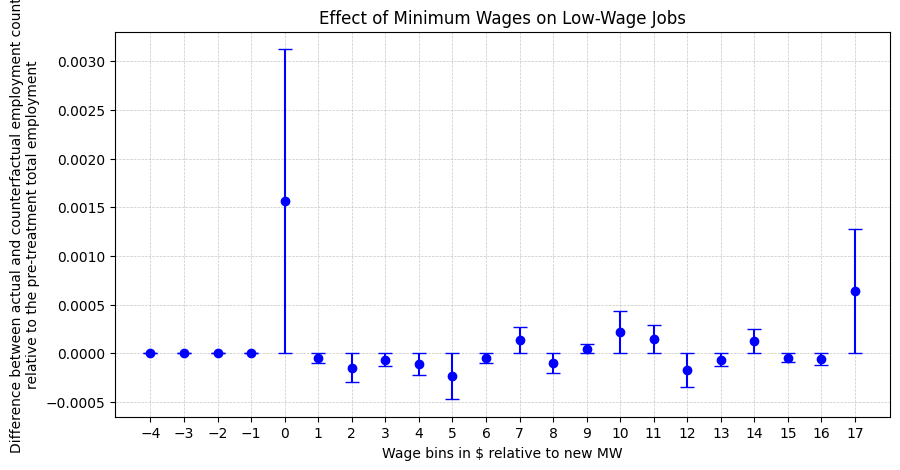

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Example data directly from your regression output coefficients
# Assuming 'coefficients' are structured as: {'treat_p0': value, 'treat_p0_lower': low_ci, 'treat_p0_upper': up_ci, ...}

# Define the bounds of your data, assume wage bins from -4 to +17 as example
wage_bins = range(-4, 18)  # From -4 to 17

# Extracting data from the coefficients
estimates = [coefficients.get(f'treat_p{abs(k)}', 0) if k >= 0 else coefficients.get(f'treat_m{abs(k)}', 0) for k in wage_bins]
ci_lower = [coefficients.get(f'treat_p{abs(k)}_lower', 0) if k >= 0 else coefficients.get(f'treat_m{abs(k)}_lower', 0) for k in wage_bins]
ci_upper = [coefficients.get(f'treat_p{abs(k)}_upper', 0) if k >= 0 else coefficients.get(f'treat_m{abs(k)}_upper', 0) for k in wage_bins]

# Plotting
plt.figure(figsize=(10, 5))
plt.errorbar(wage_bins, estimates, yerr=[np.abs(np.subtract(estimates, ci_lower)), np.abs(np.subtract(ci_upper, estimates))],
             fmt='o', capsize=5, color='blue', label='Confidence Interval')

plt.xlabel("Wage bins in $ relative to new MW")
plt.ylabel("Difference between actual and counterfactual employment count\nrelative to the pre-treatment total employment")
plt.title("Effect of Minimum Wages on Low-Wage Jobs")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(np.arange(min(wage_bins), max(wage_bins)+1, 1))  # Improved x-axis granularity

plt.show()
